# About this notebook
This notebook is adapted from the original notebook of the Stardist repository for 3D segmentation found [here](https://github.com/stardist/stardist/tree/master/examples/3D)

In [1]:
# Import packages
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import os
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

In [7]:
# Define paths
img_path = '../../../data/'
label_path = '../../../processing/Output/Segmentation/stardist_training_labels/'

# Build full list of all images
img_paths = sorted([path for path in glob(img_path + '*H4/*DAPI.TIF') if "SR" not in path if "neg" not in path if "Temp" not in path if "LiveSr" not in path])
label_paths = sorted(glob(label_path + '*'))

# Check that for each image we have annotations!
assert len(label_paths) == len(img_paths), "Images and labels don't correspond!"

In [70]:
X, Y = img_paths, label_paths

# Check for correspondence of data and annotations
for idx in range(len(X)):
    print(os.path.basename(X[idx]), '-->' ,os.path.basename(Y[idx]))

Auxin_1_w1SPI 405 DAPI.TIF --> 20221201_H4-Auxin_1_w1SPI 405 DAPI_cellpose_curated.tif
Auxin_2_w1SPI 405 DAPI.TIF --> 20221201_H4-Auxin_2_w1SPI 405 DAPI_cellpose_curated.tif
crtl-1_w1SPI 405 DAPI.TIF --> 20221201_H4-crtl-1_w1SPI 405 DAPI_cellpose_curated.tif
crtl-2_w1SPI 405 DAPI.TIF --> 20221201_H4-crtl-2_w1SPI 405 DAPI_cellpose_curated.tif
Auxin_1_w2SPI 405 DAPI.TIF --> 20221208_H4-Auxin_1_w2SPI 405 DAPI_cellpose_curated.tif
Auxin_2_w2SPI 405 DAPI.TIF --> 20221208_H4-Auxin_2_w2SPI 405 DAPI_cellpose_curated.tif
Auxin_3_w2SPI 405 DAPI.TIF --> 20221208_H4-Auxin_3_w2SPI 405 DAPI_cellpose_curated.tif
Auxin_5_w2SPI 405 DAPI.TIF --> 20221208_H4-Auxin_5_w2SPI 405 DAPI_cellpose_curated.tif
crtl_1_w1SPI 405 DAPI.TIF --> 20221208_H4-crtl_1_w1SPI 405 DAPI_cellpose_curated.tif
crtl_2_w2SPI 405 DAPI.TIF --> 20221208_H4-crtl_2_w2SPI 405 DAPI_cellpose_curated.tif
crtl_3_w2SPI 405 DAPI.TIF --> 20221208_H4-crtl_3_w2SPI 405 DAPI_cellpose_curated.tif
crtl_4_w2SPI 405 DAPI.TIF --> 20221208_H4-crtl_4_w2SP

In [71]:
# Actually load all images as big lists
X = list(map(imread,X))
Y = list(map(imread,Y))

In [72]:
# Calculate anisotropy of data
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (7.953703703703703, 1.0, 1.0082159624413145)


# Example image

In [77]:
# Select image with the i variable
i = 0
# Fill the holes that might be there from manual annotation
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (3,4)
# assumed axes ordering of img and lbl is: ZYX(C)

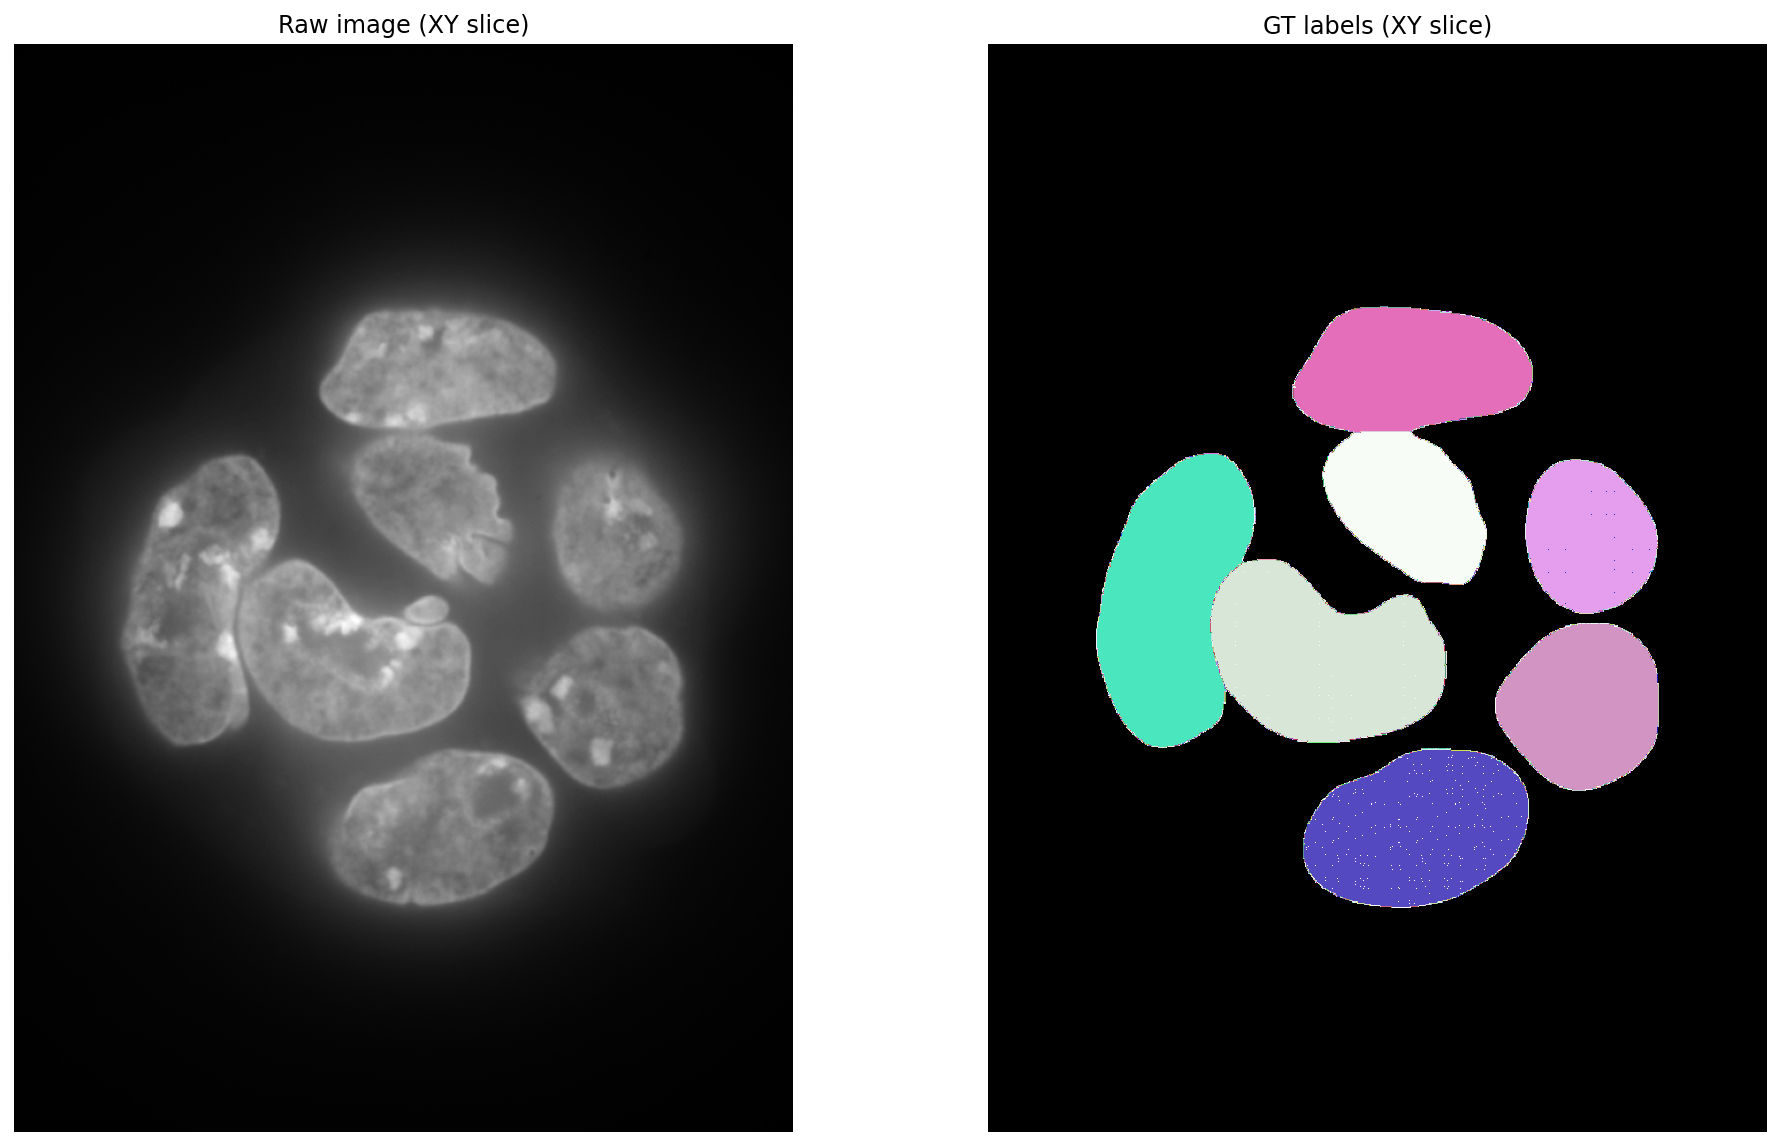

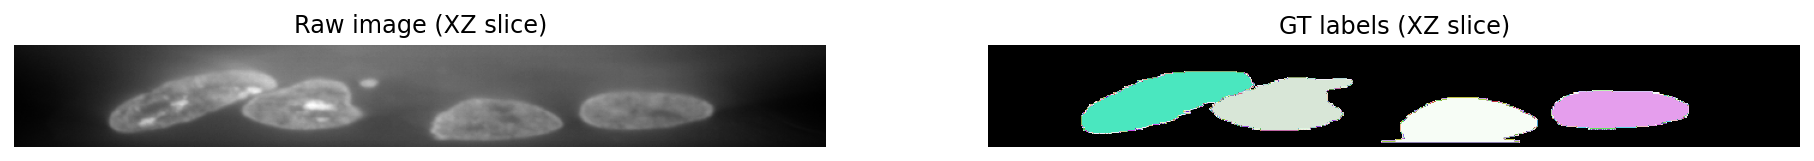

In [78]:
# Show segmentation of selected image
plt.figure(figsize=(16,10))
z = img.shape[0] // 2
y = img.shape[1] // 2
plt.subplot(121); plt.imshow(img[z],cmap='gray');   plt.axis('off'); plt.title('Raw image (XY slice)')
plt.subplot(122); plt.imshow(lbl[z],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XY slice)')
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img[:,y],cmap='gray');   plt.axis('off'); plt.title('Raw image (XZ slice)')
plt.subplot(122); plt.imshow(lbl[:,y],cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels (XZ slice)')
None;

# Fitting ground-truth labels with star-convex polyhedra

In [79]:
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

In [80]:
n_rays = [8, 16, 32, 64, 96, 128]
scores_iso   = reconstruction_scores(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores(n_rays, anisotropy=anisotropy)

100%|██████████| 6/6 [30:17<00:00, 302.92s/it]


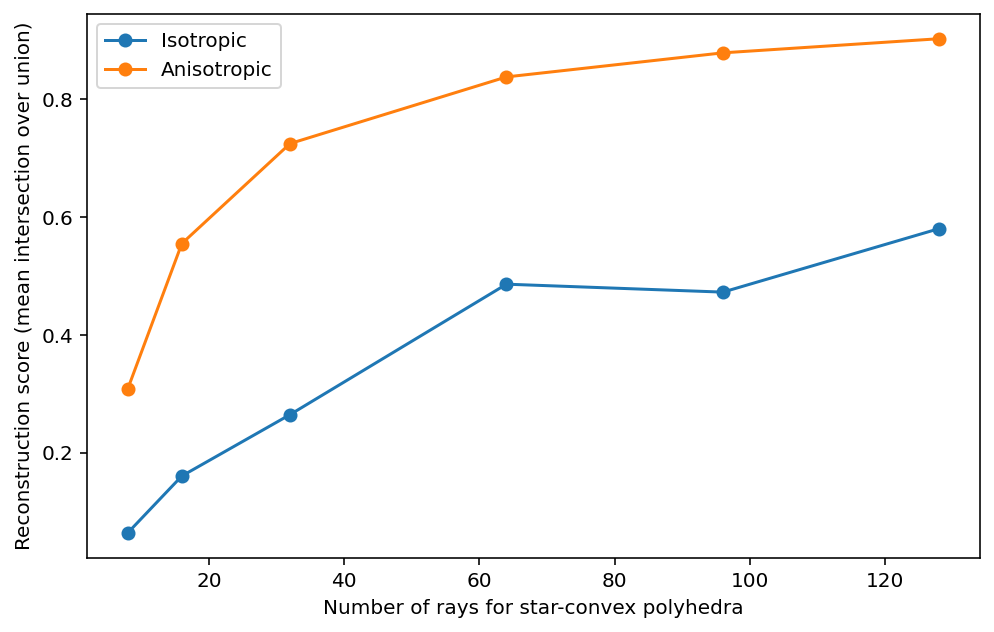

In [81]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores_iso,   'o-', label='Isotropic')
plt.plot(n_rays, scores_aniso, 'o-', label='Anisotropic')
plt.xlabel('Number of rays for star-convex polyhedra')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.legend()
None;

# Example image reconstructed with various number of rays

## Without taking anisotropy into account

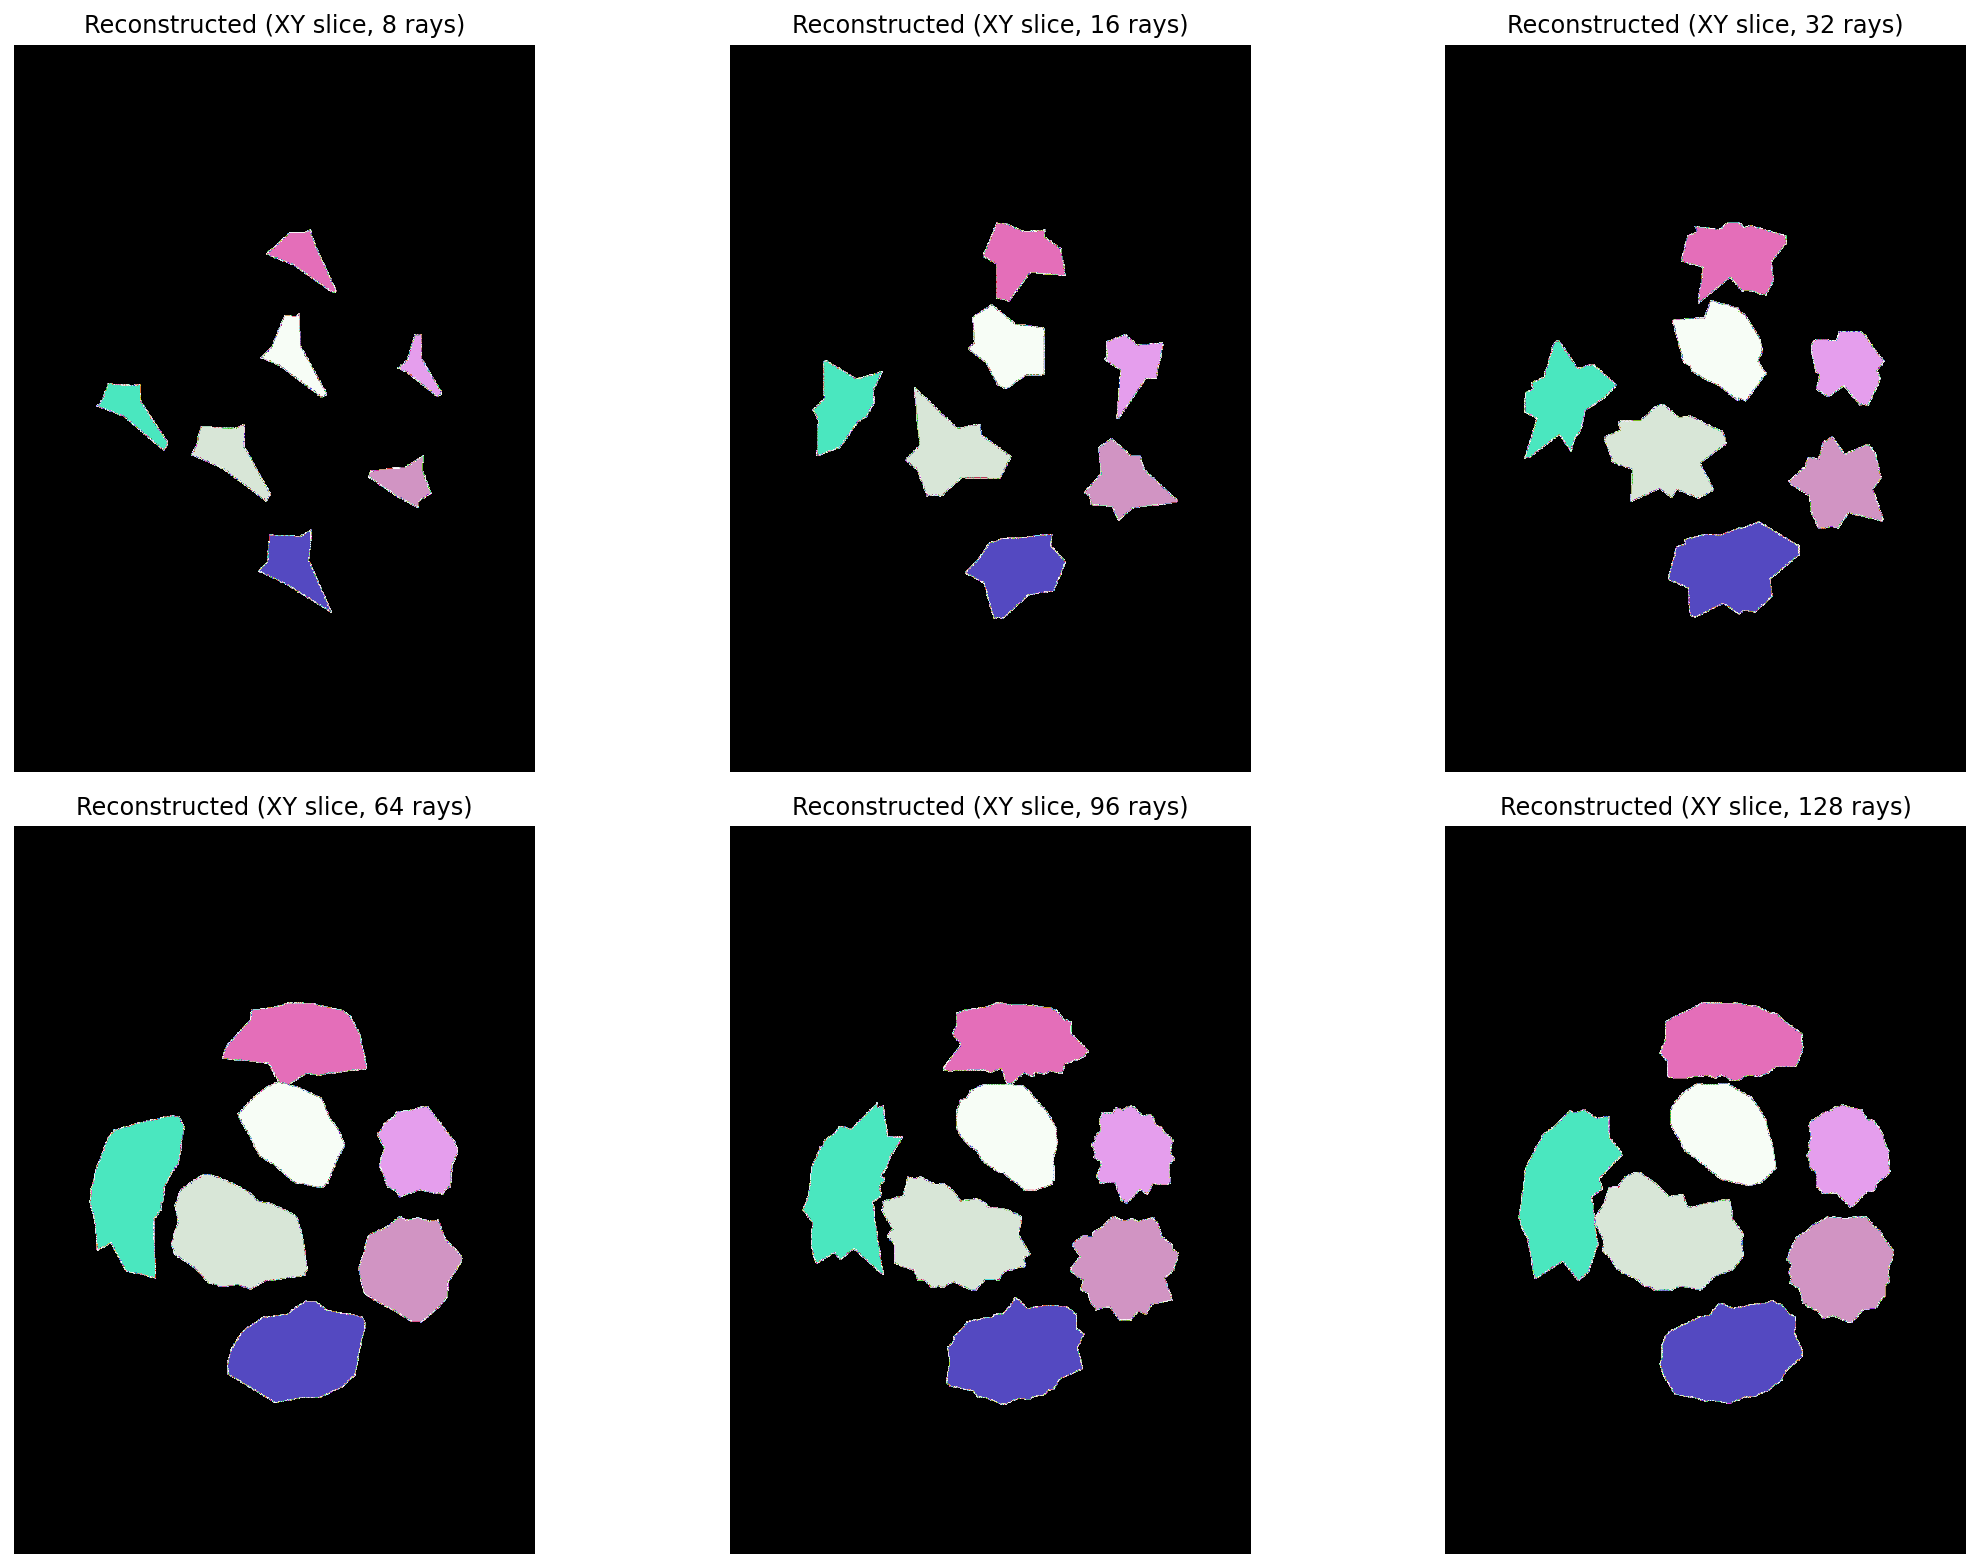

In [82]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=None)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();

## Taking anisotropy into account

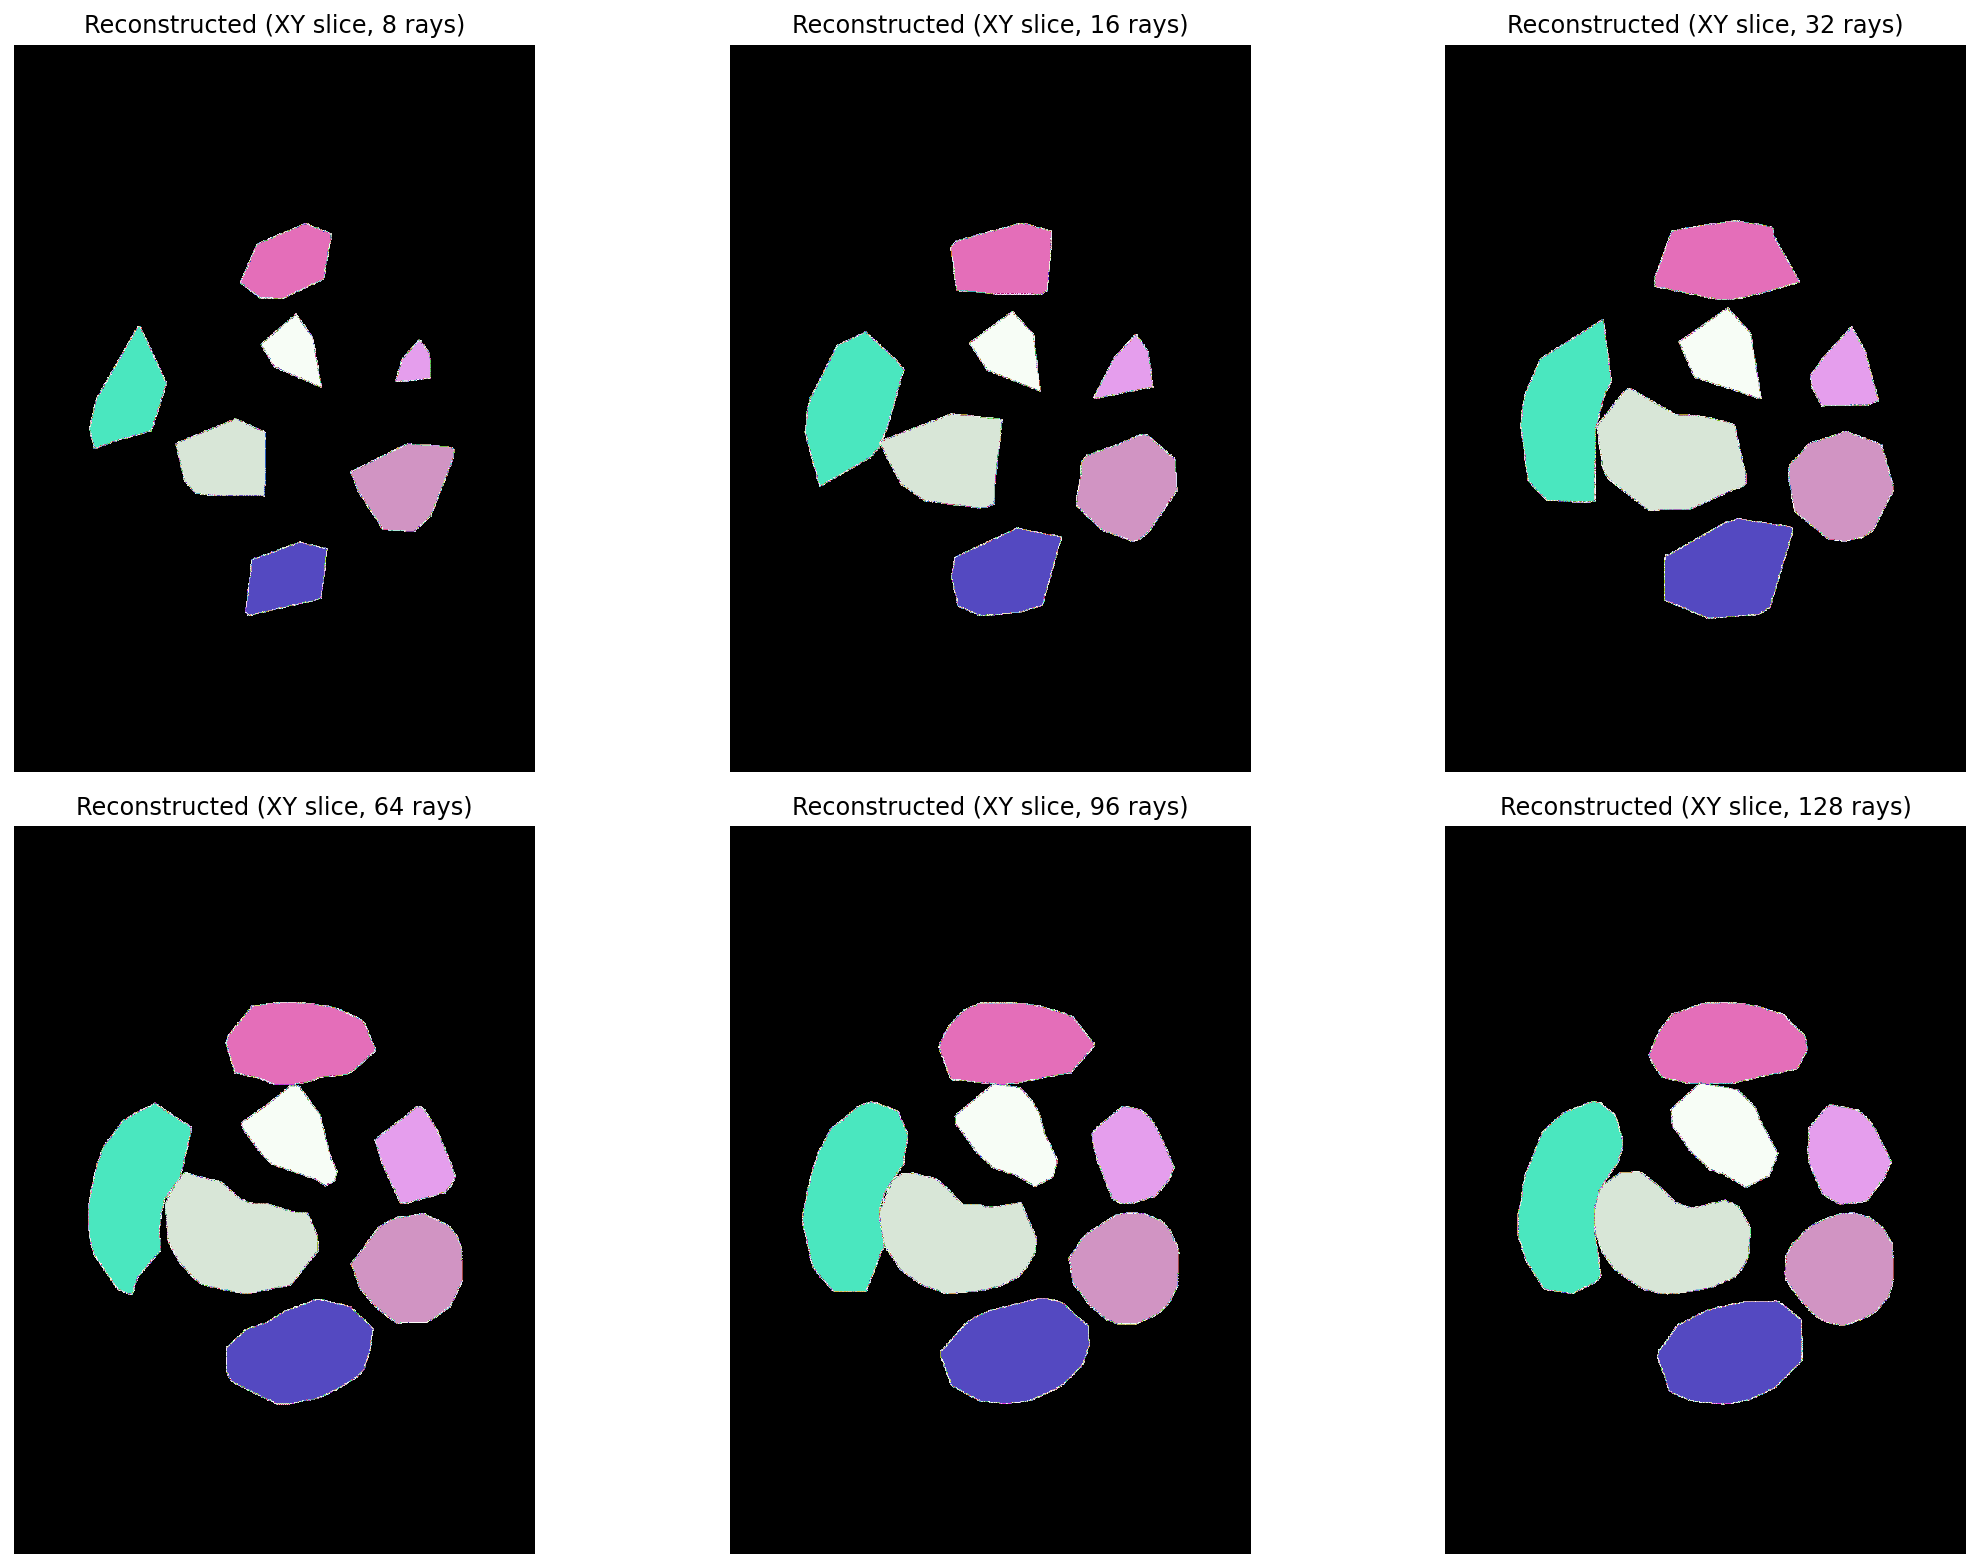

In [83]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();